**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting.
%matplotlib inline
sns.set(style="whitegrid")

# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


** Step 2: Load the Cleaned Data**

In [2]:
# Define the path to your cleaned CSV file.
CLEANED_CSV_PATH = '/content/drive/MyDrive/Ransomware-Detection/Dataset/ProcessedMetadata/cleaned_train_metadata.csv'
df = pd.read_csv(CLEANED_CSV_PATH)

print("Cleaned DataFrame shape:", df.shape)
print("Columns in DataFrame:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())


Cleaned DataFrame shape: (600000, 11)
Columns in DataFrame: ['sha256', 'md5', 'label', 'avclass', 'general_size', 'general_exports', 'general_imports', 'strings_numstrings', 'year', 'month', 'month_year']

First 5 rows:
                                              sha256  \
0  0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...   
1  c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...   
2  eac8ddb4970f8af985742973d6f0e06902d42a3684d791...   
3  7f513818bcc276c531af2e641c597744da807e21cc1160...   
4  ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...   

                                md5  label avclass  general_size  \
0  63956d6417f8f43357d9a8e79e52257e      0       0       3101705   
1  6f7bde7a1126debf0cc359a54953efc1      0       0        504320   
2  7520c8f9534ca818726a4feaebf49e2b      0       0        180224   
3  e435a536968941854bcec3b902c439f6      0       0       2377730   
4  e93049e2df82ab26f35ad0049173cb14      0       0       1153808   

   general_exports  general_import

**Step 3: Data Preprocessing for Modeling**

In [3]:
# Drop identifier fields (for modeling, identifiers aren’t used as features; keep them for logging in the final UI)
cols_to_drop = ['sha256', 'md5', 'avclass', 'month_year']
df_model = df.drop(columns=cols_to_drop, errors='ignore')
df_model['label'] = df_model['label'].astype(int)

# Separate features and target.
X = df_model.drop('label', axis=1)
y = df_model['label']

print("\nFeatures used for modeling:")
print(X.columns.tolist())
print("Shape of features:", X.shape)



Features used for modeling:
['general_size', 'general_exports', 'general_imports', 'strings_numstrings', 'year', 'month']
Shape of features: (600000, 6)


**Step 4: Split Data into Training and Validation Sets**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)


Training set shape: (480000, 6) (480000,)
Validation set shape: (120000, 6) (120000,)


**Step 5: Train and Evaluate Model 1 - Random Forest**

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
rf_report = classification_report(y_val, y_pred_rf)
rf_auc = roc_auc_score(y_val, rf_clf.predict_proba(X_val)[:, 1])

print("\nRandom Forest Classification Report:")
print(rf_report)
print("Random Forest ROC-AUC:", rf_auc)



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     59929
           1       0.91      0.90      0.90     60071

    accuracy                           0.91    120000
   macro avg       0.91      0.91      0.91    120000
weighted avg       0.91      0.91      0.91    120000

Random Forest ROC-AUC: 0.9714366862534266


**Step 6: Train and Evaluate Model 2 - XGBoost**

In [7]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_val)
xgb_report = classification_report(y_val, y_pred_xgb)
xgb_auc = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])

print("\nXGBoost Classification Report:")
print(xgb_report)
print("XGBoost ROC-AUC:", xgb_auc)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     59929
           1       0.86      0.87      0.86     60071

    accuracy                           0.86    120000
   macro avg       0.86      0.86      0.86    120000
weighted avg       0.86      0.86      0.86    120000

XGBoost ROC-AUC: 0.9442695705730293


**Step 7: Train and Evaluate Model 3 - Deep Learning Model (FNN)**

In [5]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Enable GPU memory growth if desired (optional)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Scale features for the deep learning model.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

def create_improved_deep_model(input_dim):
    model = Sequential()
    # Optional: Use an explicit input layer.
    model.add(InputLayer(input_shape=(input_dim,)))

    # Layer 1: Increase capacity with 512 neurons.
    model.add(Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))

    # Layer 2: 256 neurons.
    model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))

    # Layer 3: 128 neurons.
    model.add(Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.4))

    # Layer 4: 64 neurons.
    model.add(Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.4))

    # Output Layer: binary classification.
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the model.
improved_baseline_dl_model = create_improved_deep_model(X_train_scaled.shape[1])

# Define callbacks.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_baseline_dl_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the improved baseline model (use correct variable name here).
history_improved_baseline = improved_baseline_dl_model.fit(
    X_train_scaled, y_train,
    epochs=50,   # Adjust epochs if necessary.
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)

# Evaluate the improved baseline model.
loss_baseline, acc_baseline = improved_baseline_dl_model.evaluate(X_val_scaled, y_val, verbose=0)
y_pred_baseline_prob = improved_baseline_dl_model.predict(X_val_scaled).ravel()
y_pred_baseline = (y_pred_baseline_prob > 0.5).astype(int)
from sklearn.metrics import classification_report, roc_auc_score
baseline_dl_report = classification_report(y_val, y_pred_baseline)
baseline_dl_auc = roc_auc_score(y_val, y_pred_baseline_prob)

print("\nBest Baseline Deep Learning Model Classification Report:")
print(baseline_dl_report)
print("Best Baseline Deep Learning Model ROC-AUC:", baseline_dl_auc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
14987/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6214 - loss: 0.8108
Epoch 1: val_loss improved from inf to 0.65917, saving model to best_baseline_dl_model.h5


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.6214 - loss: 0.8107 - val_accuracy: 0.6224 - val_loss: 0.6592 - learning_rate: 0.0010
Epoch 2/50
14989/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6407 - loss: 0.6654
Epoch 2: val_loss did not improve from 0.65917
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.6407 - loss: 0.6654 - val_accuracy: 0.6166 - val_loss: 0.6595 - learning_rate: 0.0010
Epoch 3/50
14993/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6424 - loss: 0.6573
Epoch 3: val_loss improved from 0.65917 to 0.64843, saving model to best_baseline_dl_model.h5


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.6424 - loss: 0.6573 - val_accuracy: 0.6187 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 4/50
14992/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6452 - loss: 0.6518
Epoch 4: val_loss did not improve from 0.64843
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.6452 - loss: 0.6518 - val_accuracy: 0.6090 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 5/50
14982/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6471 - loss: 0.6469
Epoch 5: val_loss did not improve from 0.64843
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.6471 - loss: 0.6469 - val_accuracy: 0.6358 - val_loss: 0.6559 - learning_rate: 0.0010
Epoch 6/50
14992/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6467 - loss: 0.6440
Epoch 6: val_loss improved from 0.64843 to 0.64648, saving model to best_baseline_dl_model.h5


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.6467 - loss: 0.6440 - val_accuracy: 0.6388 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 7/50
14992/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6453 - loss: 0.6425
Epoch 7: val_loss improved from 0.64648 to 0.64419, saving model to best_baseline_dl_model.h5


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.6453 - loss: 0.6425 - val_accuracy: 0.6513 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 8/50
14990/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6471 - loss: 0.6396
Epoch 8: val_loss did not improve from 0.64419
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.6471 - loss: 0.6396 - val_accuracy: 0.6306 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 9/50
14992/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6465 - loss: 0.6386
Epoch 9: val_loss improved from 0.64419 to 0.64190, saving model to best_baseline_dl_model.h5


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.6465 - loss: 0.6386 - val_accuracy: 0.6160 - val_loss: 0.6419 - learning_rate: 0.0010
Epoch 10/50
14998/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6460 - loss: 0.6381
Epoch 10: val_loss did not improve from 0.64190
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.6460 - loss: 0.6381 - val_accuracy: 0.6232 - val_loss: 0.6551 - learning_rate: 0.0010
Epoch 11/50
14982/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6470 - loss: 0.6358
Epoch 11: val_loss did not improve from 0.64190
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - accuracy: 0.6470 - loss: 0.6358 - val_accuracy: 0.6350 - val_loss: 0.6454 - learning_rate: 0.0010
Epoch 12/50
14989/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6438 - loss: 0.6364
Epoch 12: val_loss did not improve from 0.64190
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.6438 - loss: 0.6364 - val_accuracy: 0.6176 - val_loss: 0.6433 - learning_rate: 0.0010

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.6447 - loss: 0.6362 - val_accuracy: 0.6246 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 15/50
14983/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6448 - loss: 0.6348
Epoch 15: val_loss did not improve from 0.63616
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.6448 - loss: 0.6348 - val_accuracy: 0.6279 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 16/50
14996/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6455 - loss: 0.6335
Epoch 16: val_loss did not improve from 0.63616
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.6455 - loss: 0.6335 - val_accuracy: 0.6072 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 17/50
14993/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6442 - loss: 0.6339
Epoch 17: val_loss improved from 0.63616 to 0.63369, saving model to best_baseline_dl_model.h5


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.6442 - loss: 0.6339 - val_accuracy: 0.6302 - val_loss: 0.6337 - learning_rate: 0.0010
Epoch 18/50
14995/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6451 - loss: 0.6330
Epoch 18: val_loss did not improve from 0.63369
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.6451 - loss: 0.6330 - val_accuracy: 0.6143 - val_loss: 0.6451 - learning_rate: 0.0010
Epoch 19/50
14996/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6451 - loss: 0.6339
Epoch 19: val_loss did not improve from 0.63369
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.6451 - loss: 0.6339 - val_accuracy: 0.6506 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 20/50
14992/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6439 - loss: 0.6333
Epoch 20: val_loss improved from 0.63369 to 0.62983, saving model to best_baseline_dl_model.h5


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.6439 - loss: 0.6333 - val_accuracy: 0.6154 - val_loss: 0.6298 - learning_rate: 0.0010
Epoch 21/50
14997/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6436 - loss: 0.6331
Epoch 21: val_loss did not improve from 0.62983
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.6436 - loss: 0.6331 - val_accuracy: 0.6323 - val_loss: 0.6367 - learning_rate: 0.0010
Epoch 22/50
14986/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6436 - loss: 0.6325
Epoch 22: val_loss did not improve from 0.62983
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.6436 - loss: 0.6325 - val_accuracy: 0.6155 - val_loss: 0.6333 - learning_rate: 0.0010
Epoch 23/50
14992/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6436 - loss: 0.6320
Epoch 23: val_loss did not improve from 0.62983
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.6436 - loss: 0.6320 - val_accuracy: 0.6107 - val_loss: 0.6520 - learning_rate: 0.0010

**Step 8: Train and Evaluate Model 4 - Specialized Deep Learning Model (TabNet)**

In [8]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Convert the training and validation sets to NumPy arrays.
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int64)
y_val_np = y_val.values.astype(np.int64)

tabnet_clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'  # Alternatively, 'sparsemax'
)

# Fit the TabNet model.
tabnet_clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric=['auc'],
    max_epochs=50,  # You might try fewer epochs initially if training time is limited.
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

tabnet_preds = tabnet_clf.predict_proba(X_val_np)[:, 1]
tabnet_auc = roc_auc_score(y_val_np, tabnet_preds)
print("\nTabNet ROC-AUC:", tabnet_auc)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53691 | val_0_auc: 0.66798 |  0:01:25s
epoch 1  | loss: 0.48644 | val_0_auc: 0.66005 |  0:02:54s
epoch 2  | loss: 0.46301 | val_0_auc: 0.64173 |  0:04:19s
epoch 3  | loss: 0.44559 | val_0_auc: 0.73379 |  0:05:43s
epoch 4  | loss: 0.43452 | val_0_auc: 0.65852 |  0:07:12s
epoch 5  | loss: 0.4261  | val_0_auc: 0.6928  |  0:08:37s
epoch 6  | loss: 0.41725 | val_0_auc: 0.66906 |  0:10:02s
epoch 7  | loss: 0.41167 | val_0_auc: 0.64192 |  0:11:27s
epoch 8  | loss: 0.40613 | val_0_auc: 0.55779 |  0:12:52s
epoch 9  | loss: 0.40332 | val_0_auc: 0.63244 |  0:14:17s
epoch 10 | loss: 0.4     | val_0_auc: 0.59183 |  0:15:44s
epoch 11 | loss: 0.39801 | val_0_auc: 0.67986 |  0:17:10s
epoch 12 | loss: 0.39761 | val_0_auc: 0.67457 |  0:18:34s
epoch 13 | loss: 0.39336 | val_0_auc: 0.67083 |  0:20:00s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.73379


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



TabNet ROC-AUC: 0.7337889526472529


**Step 9: Ensemble Model Predictions**

In [10]:
# Get predicted probabilities from each model.
rf_probs = rf_clf.predict_proba(X_val)[:, 1]
xgb_probs = xgb_clf.predict_proba(X_val)[:, 1]
improved_baseline_dl_probs = improved_baseline_dl_model.predict(X_val_scaled).ravel()
tabnet_probs = tabnet_preds  # from TabNet

# Ensemble: Average the probabilities from all models.
ensemble_probs = (rf_probs + xgb_probs + improved_baseline_dl_probs + tabnet_probs) / 4.0
ensemble_preds = (ensemble_probs > 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score
ensemble_report = classification_report(y_val, ensemble_preds)
ensemble_auc = roc_auc_score(y_val, ensemble_probs)

print("\nWeighted Ensemble Model Classification Report:")
print(ensemble_report)
print("Weighted Ensemble Model ROC-AUC:", ensemble_auc)


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Weighted Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     59929
           1       0.96      0.80      0.87     60071

    accuracy                           0.88    120000
   macro avg       0.89      0.88      0.88    120000
weighted avg       0.89      0.88      0.88    120000

Weighted Ensemble Model ROC-AUC: 0.965469580675599


**Step 10 Stacking Ensemble (Meta-model)**

In [12]:
from sklearn.linear_model import LogisticRegression

# Create stacking features for training.
rf_probs_train = rf_clf.predict_proba(X_train)[:, 1]
xgb_probs_train = xgb_clf.predict_proba(X_train)[:, 1]
# Replace baseline_dl_model with improved_baseline_dl_model
baseline_dl_probs_train = improved_baseline_dl_model.predict(scaler.transform(X_train)).ravel()
tabnet_probs_train = tabnet_clf.predict_proba(X_train_np)[:, 1]

stacking_features_train = np.column_stack((rf_probs_train, xgb_probs_train, baseline_dl_probs_train, tabnet_probs_train))

# And for validation.
stacking_features_val = np.column_stack((
    rf_clf.predict_proba(X_val)[:, 1],
    xgb_clf.predict_proba(X_val)[:, 1],
    improved_baseline_dl_model.predict(X_val_scaled).ravel(),
    tabnet_clf.predict_proba(X_val_np)[:, 1]
))

meta_model = LogisticRegression()
meta_model.fit(stacking_features_train, y_train)

ensemble_probs_stacking = meta_model.predict_proba(stacking_features_val)[:, 1]
ensemble_preds_stacking = (ensemble_probs_stacking > 0.5).astype(int)
ensemble_report_stacking = classification_report(y_val, ensemble_preds_stacking)
ensemble_auc_stacking = roc_auc_score(y_val, ensemble_probs_stacking)

print("\nStacking Ensemble Model Classification Report:")
print(ensemble_report_stacking)
print("Stacking Ensemble Model ROC-AUC:", ensemble_auc_stacking)


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

Stacking Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     59929
           1       0.91      0.90      0.90     60071

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       0.90      0.90      0.90    120000

Stacking Ensemble Model ROC-AUC: 0.9671730472275919


**Step 11: Compare the Models**

In [13]:
models = ['Random Forest', 'XGBoost', 'Baseline Deep Learning', 'TabNet', 'Weighted Ensemble', 'Stacking Ensemble']
roc_auc_scores = [rf_auc, xgb_auc, baseline_dl_auc, tabnet_auc, ensemble_auc, ensemble_auc_stacking]
comparison_df = pd.DataFrame({'Model': models, 'ROC-AUC': roc_auc_scores})
print("\nComparison of ROC-AUC scores:")
print(comparison_df)



Comparison of ROC-AUC scores:
                    Model   ROC-AUC
0           Random Forest  0.971437
1                 XGBoost  0.944270
2  Baseline Deep Learning  0.742665
3                  TabNet  0.733789
4       Weighted Ensemble  0.965470
5       Stacking Ensemble  0.967173


**Step 12: Save the Models for Future Use**

In [15]:
model_folder = '/content/drive/MyDrive/Ransomware-Detection/Models'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

joblib.dump(rf_clf, os.path.join(model_folder, 'rf_model.pkl'))
joblib.dump(xgb_clf, os.path.join(model_folder, 'xgb_model.pkl'))
joblib.dump(meta_model, os.path.join(model_folder, 'meta_model.pkl'))
# Save the improved baseline deep learning model.
improved_baseline_dl_model.save(os.path.join(model_folder, 'baseline_deep_model.h5'))
# Save the TabNet model using its native method.
tabnet_clf.save_model(os.path.join(model_folder, 'tabnet_model'))

print("\nModels saved successfully!")


Successfully saved model at /content/drive/MyDrive/Ransomware-Detection/Models/tabnet_model.zip

Models saved successfully!


**Step 13: Plots and Graphs**

13.1 Helper Functions

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report, roc_auc_score

# -----------------------------
# Helper Functions for Evaluation and Plotting
# -----------------------------
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.3f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

def plot_precision_recall_curve(y_true, y_prob, title="Precision-Recall Curve"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

def evaluate_model(y_true, y_prob, model_name="Model"):
    y_pred = (y_prob > 0.5).astype(int)
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    roc_auc_val = roc_auc_score(y_true, y_prob)
    print(f"{model_name} ROC-AUC: {roc_auc_val:.3f}")
    plot_confusion_matrix(y_true, y_pred, title=f"{model_name} Confusion Matrix")
    plot_roc_curve(y_true, y_prob, title=f"{model_name} ROC Curve")
    plot_precision_recall_curve(y_true, y_prob, title=f"{model_name} Precision-Recall Curve")
    return roc_auc_val


13.2 Models Evaluation

Evaluating models on the validation set...


Evaluating Random Forest:
--- Random Forest ---
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     59929
           1       0.91      0.90      0.90     60071

    accuracy                           0.91    120000
   macro avg       0.91      0.91      0.91    120000
weighted avg       0.91      0.91      0.91    120000

Random Forest ROC-AUC: 0.971


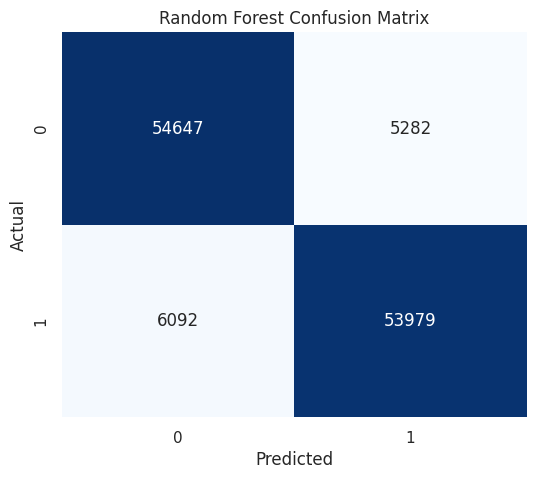

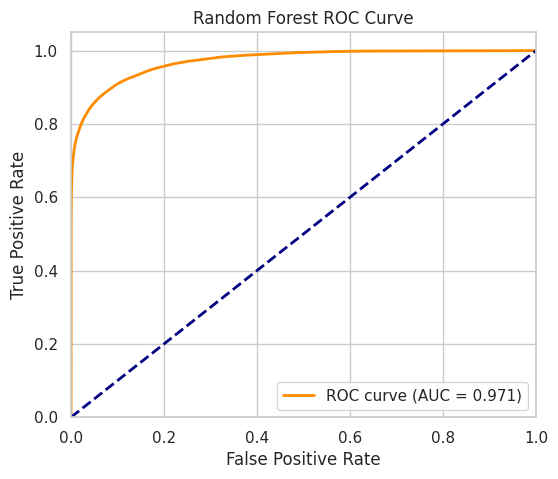

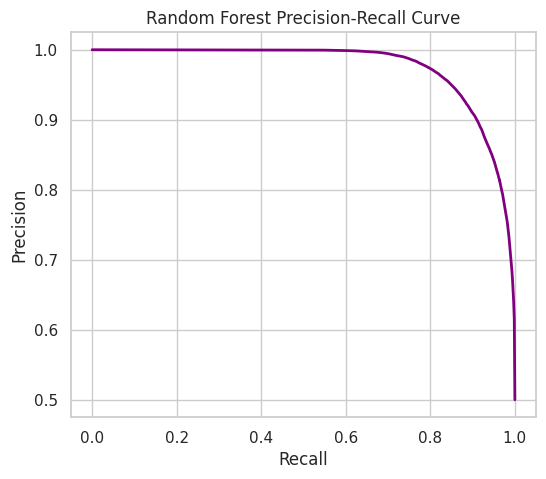


Evaluating XGBoost:
--- XGBoost ---
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     59929
           1       0.86      0.87      0.86     60071

    accuracy                           0.86    120000
   macro avg       0.86      0.86      0.86    120000
weighted avg       0.86      0.86      0.86    120000

XGBoost ROC-AUC: 0.944


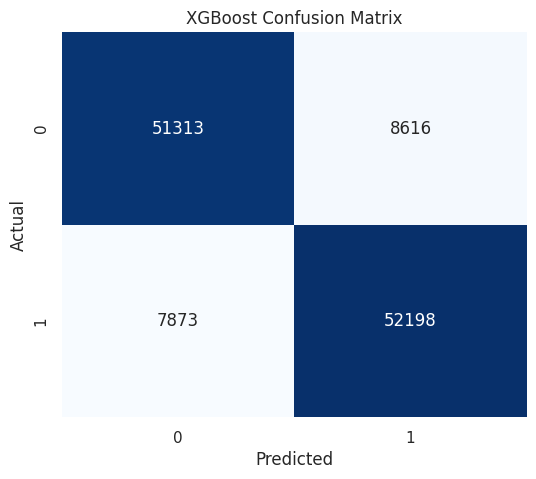

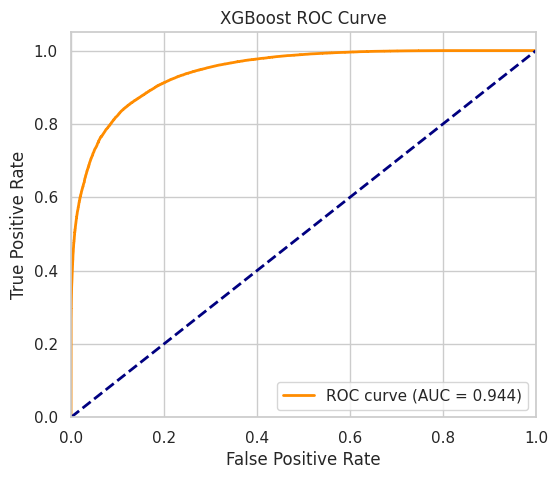

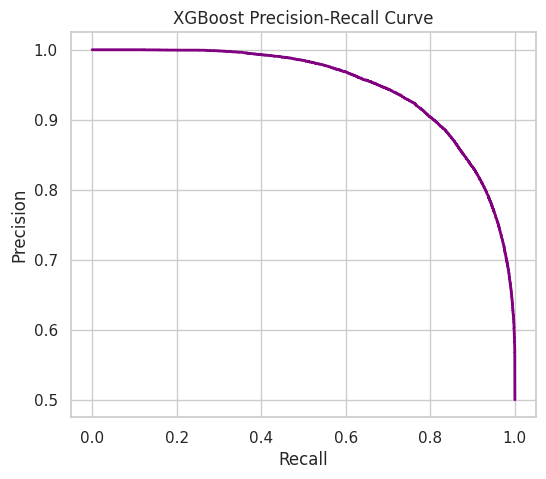


Evaluating Baseline Deep Learning:
--- Baseline Deep Learning ---
              precision    recall  f1-score   support

           0       0.82      0.29      0.43     59929
           1       0.57      0.94      0.71     60071

    accuracy                           0.62    120000
   macro avg       0.70      0.61      0.57    120000
weighted avg       0.70      0.62      0.57    120000

Baseline Deep Learning ROC-AUC: 0.743


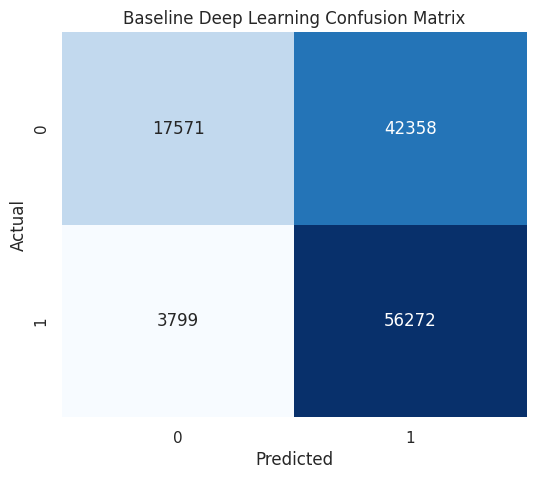

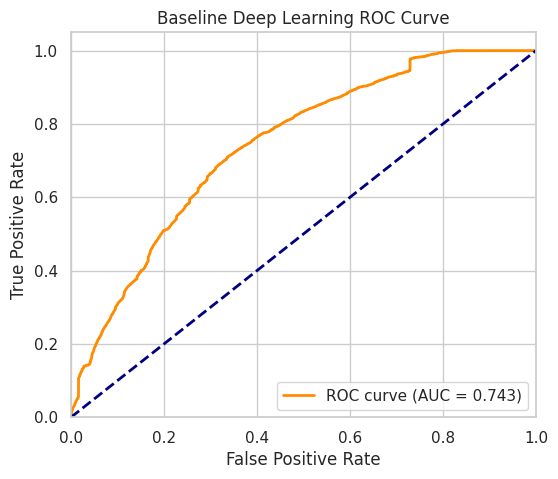

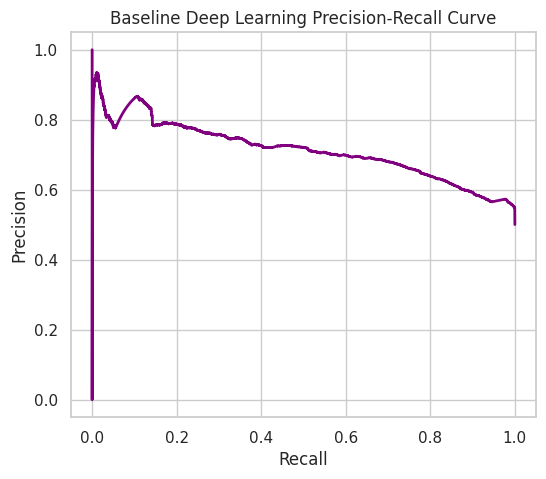


Evaluating TabNet:
--- TabNet ---
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     59929
           1       1.00      0.00      0.00     60071

    accuracy                           0.50    120000
   macro avg       0.75      0.50      0.33    120000
weighted avg       0.75      0.50      0.33    120000

TabNet ROC-AUC: 0.734


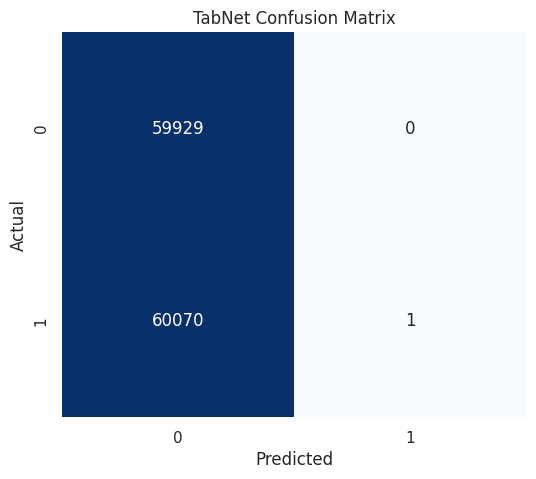

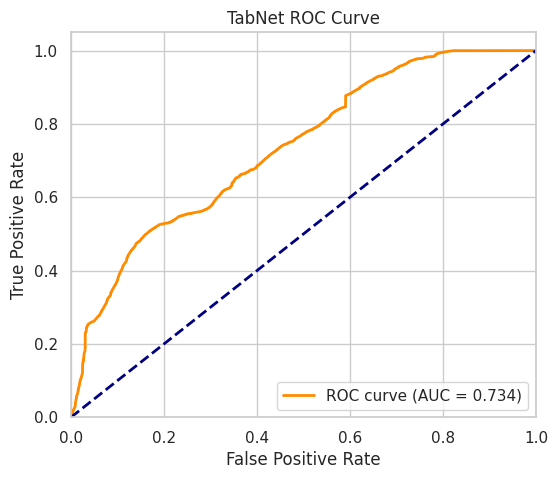

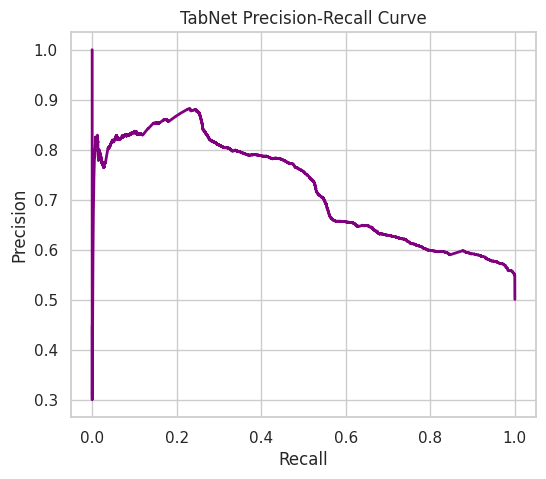


Evaluating Weighted Ensemble:
--- Weighted Ensemble ---
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     59929
           1       0.96      0.80      0.87     60071

    accuracy                           0.88    120000
   macro avg       0.89      0.88      0.88    120000
weighted avg       0.89      0.88      0.88    120000

Weighted Ensemble ROC-AUC: 0.965


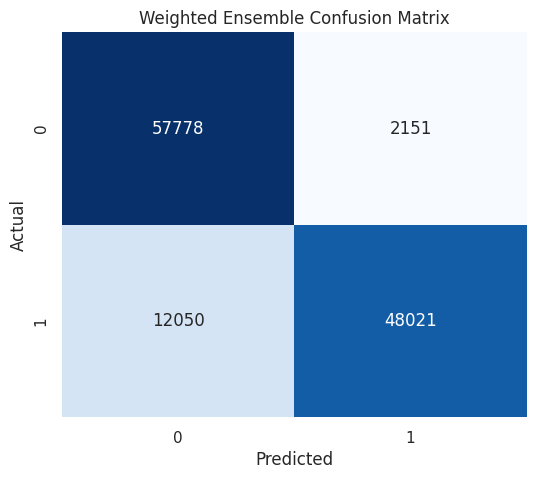

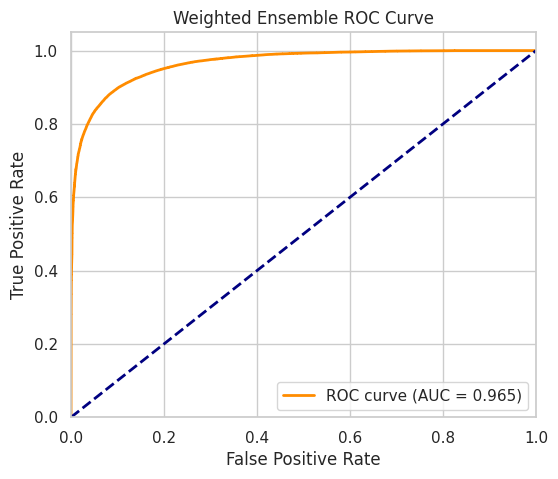

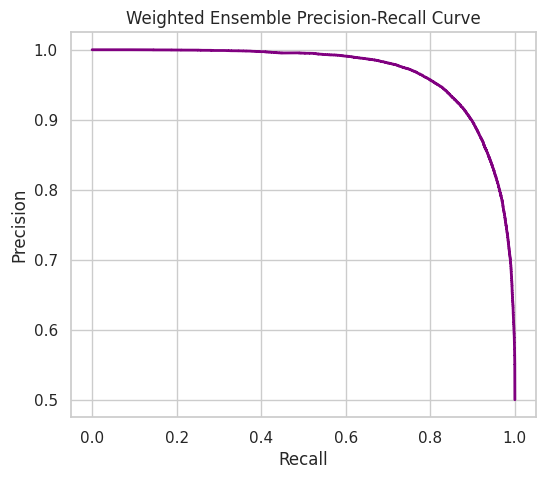


Evaluating Stacking Ensemble:
--- Stacking Ensemble ---
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     59929
           1       0.91      0.90      0.90     60071

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       0.90      0.90      0.90    120000

Stacking Ensemble ROC-AUC: 0.967


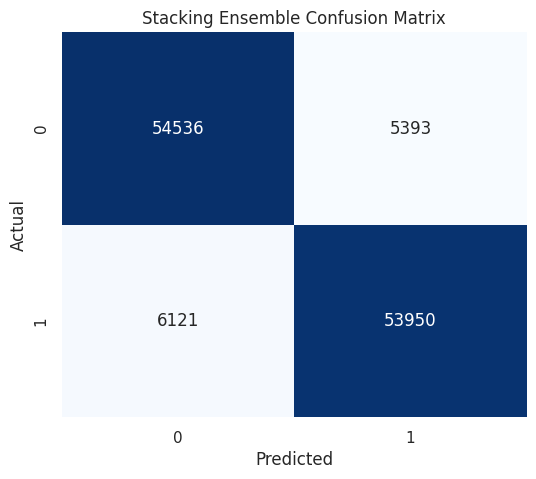

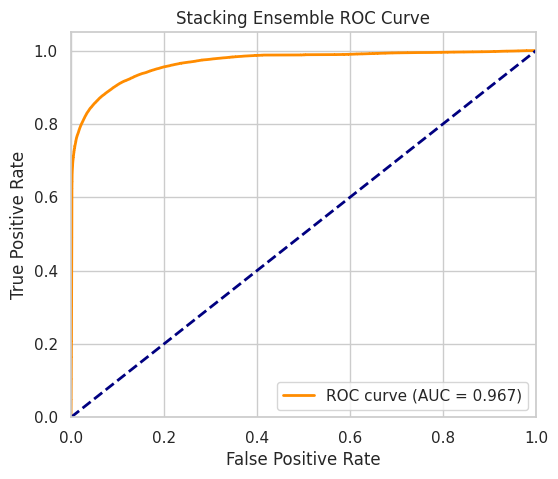

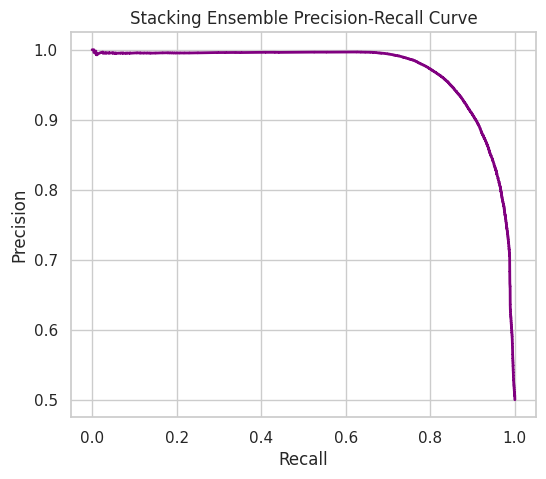

In [17]:
# -----------------------------
# Evaluate Each Model
# -----------------------------
print("Evaluating models on the validation set...\n")

model_predictions = [
    ("Random Forest", rf_clf.predict_proba(X_val)[:, 1]),
    ("XGBoost", xgb_clf.predict_proba(X_val)[:, 1]),
    ("Baseline Deep Learning", y_pred_baseline_prob),
    ("TabNet", tabnet_preds),
    ("Weighted Ensemble", ensemble_probs),
    ("Stacking Ensemble", ensemble_probs_stacking)  # if available, otherwise skip this
]

evaluation_results = {}
for model_name, y_prob in model_predictions:
    print(f"\nEvaluating {model_name}:")
    roc_auc_val = evaluate_model(y_val, y_prob, model_name=model_name)
    evaluation_results[model_name] = roc_auc_val


13.3 Models Comparison (Bar Chart)


Comparison of ROC-AUC Scores:
                    Model   ROC-AUC
0           Random Forest  0.971437
1                 XGBoost  0.944270
2  Baseline Deep Learning  0.742665
3                  TabNet  0.733789
4       Weighted Ensemble  0.965470
5       Stacking Ensemble  0.967173


<ipython-input-18-4f1383f3f090>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Model', y='ROC-AUC', palette='viridis')


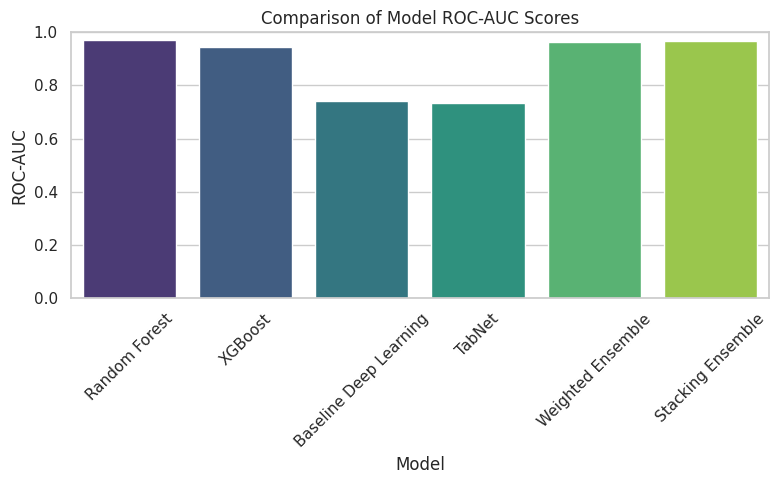

In [18]:
# -----------------------------
# Summary Comparison Bar Chart
# -----------------------------
summary_df = pd.DataFrame({
    'Model': list(evaluation_results.keys()),
    'ROC-AUC': list(evaluation_results.values())
})
print("\nComparison of ROC-AUC Scores:")
print(summary_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Model', y='ROC-AUC', palette='viridis')
plt.title("Comparison of Model ROC-AUC Scores")
plt.xlabel("Model")
plt.ylabel("ROC-AUC")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
